- 学修番号: 22745102
- 氏名: 岩間和也

# 課題 2.1　決定木分析

- 2.1.1 AUCが最大になる max_depth
- 2.1.2 決定木の描画
- 2.1.3 散布図の描画

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.tree import plot_tree

autos = pd.read_csv('data/imports-85.data', na_values='?')
autos.columns = ['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
                    'num_of_doors', 'body_style', 'drive_wheels', 'engine_location',
                    'wheel_base', 'length','width', 'height', 'curb_weight',
                    'engine_type', 'num_of_cylinders', 'engine_size', 'fuel_system',
                    'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm',
                    'city_mpg', 'highway_mpg','price']
# 表示する最大列数の設定
pd.set_option('display.max_columns', len(autos.columns))
# 欠損値 NaN がある行の除去
autos = autos.dropna()

### 2.1 で用いるDataFrame

欠損値 NaN がある行を除去した autos から symboling, normalized_losses, city_mpg, highway_mpg 列を除外したうえで、highway_mpgから中央値よりも大きければ1、小さいか等しければ0を値としたhighway_mpg_01列を追加した pandas DataFrame を作成。

In [2]:
df = autos.drop(['symboling', 'normalized_losses', 'city_mpg', 'highway_mpg'], axis=1)
# ダミー変数化
highway_mpg_median = autos.highway_mpg.median()
df['highway_mpg_01'] = \
    autos['highway_mpg'].map(lambda x: 1 if x > highway_mpg_median else 0)
df = pd.get_dummies(data=df, drop_first=True)
# 確認
print(df.groupby('highway_mpg_01').size())
df.head(1)

highway_mpg_01
0    90
1    69
dtype: int64


,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,price,highway_mpg_01,...,engine_type_l,engine_type_ohc,engine_type_ohcf,engine_type_ohcv,num_of_cylinders_five,num_of_cylinders_four,num_of_cylinders_six,num_of_cylinders_three,fuel_system_2bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi
2,99.8,176.6,66.2,54.3,2337,109,3.19,3.4,10.0,102.0,5500.0,13950.0,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0


<hr>

highway_mpg_01 を目的変数、それ以外を説明変数とし、決定木を用いて以下に答えなさい。
決定木の分類器 DecisionTreeClassifier は、以下のように criterion='entropy' と random_state=0 を引数として渡すこと。
```
DecisionTreeClassifier(random_state=0, criterion='entropy', ...)
```
- 分割の規準は、エントロピー (criterion='entropy') を用いる。
- 作成される決定木のランダム性の排除のため random_state=0 を引数として渡す。

### 2.1.1 AUCが最大になる max_depth

交差検証により、AUCが最大になる max_depth を求めなさい。
- 分割数は 10 とする。

In [3]:
X = df.drop(['highway_mpg_01'], axis=1)
Y = df.highway_mpg_01

def classify(depth):
    model = DecisionTreeClassifier(random_state=0, criterion='entropy', min_samples_split=10, max_depth=depth)
    model.fit(X, Y)
    Y_predict = model.predict(X)
    Y_proba = model.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
    auc_score = auc(fpr, tpr)
    print('depth={:2}'.format(depth))
    print(auc_score)

# 適切な深さが不明のため、少し幅を持たせて算出する
for d in range(2, 15, 1):
    classify(d)



depth= 2
0.9547504025764896
depth= 3
0.9847020933977455
depth= 4
0.9934782608695653
depth= 5
0.9968599033816425
depth= 6
0.9982286634460548
depth= 7
0.9992753623188405
depth= 8
0.9992753623188405
depth= 9
0.9992753623188405
depth=10
0.9992753623188405
depth=11
0.9992753623188405
depth=12
0.9992753623188405
depth=13
0.9992753623188405
depth=14
0.9992753623188405


<hr>

### max_depthは7以降で変わらないため max_depth = 7

<hr>

### 2.1.2 決定木の描画

2.1.1で求めた max_depth の決定木を描画しなさい。
- class_names は適切に付けること。

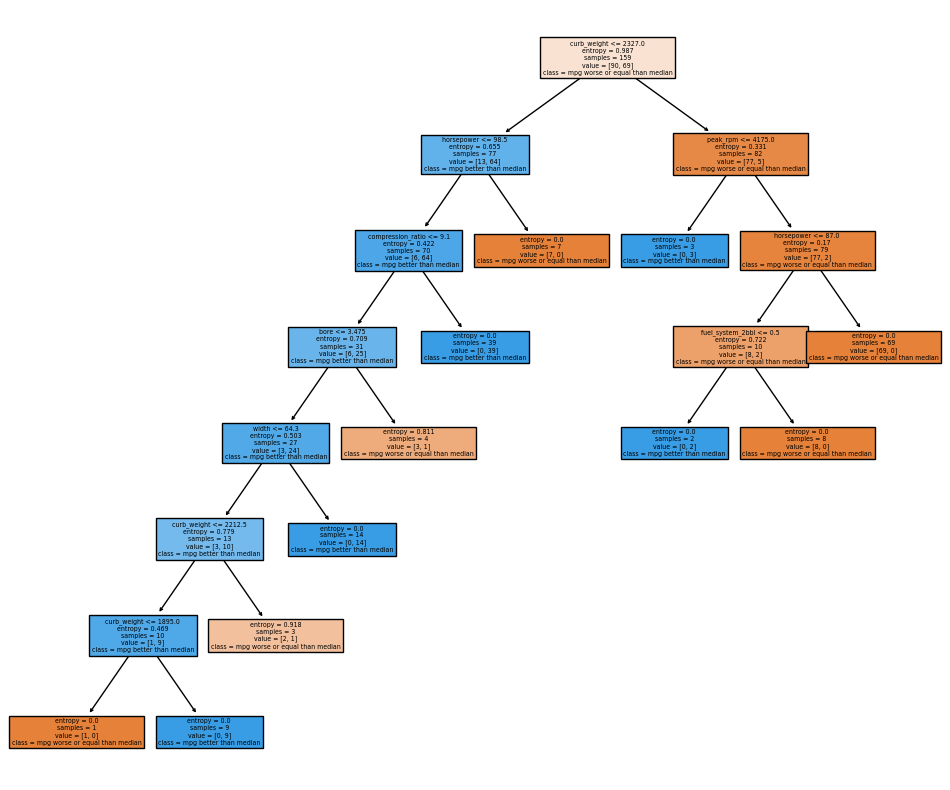

In [4]:
model2 = DecisionTreeClassifier(random_state=0, criterion='entropy', min_samples_split=10, max_depth=7)
model2.fit(X, Y)

plt.figure(figsize=(12, 10))
plot_tree(model2, 
          feature_names=X.columns, 
          class_names=['mpg worse or equal than median', 'mpg better than median'], 
          filled=True)
plt.show()

<hr>

### 2.1.3 散布図の描画

2.1.2で作成した決定木における正規化された情報利得の総和の上位2つとなる説明変数の散布図を描画しなさい。
- highway_mpg_01の値で色分けすること。
- 情報利得の総和の上位2つとなる説明変数のうち大きい方をX軸とすること。
- 2.1.2で作成した決定木の情報から領域を分割する直線を重ねてひくこと。

In [5]:
# 情報利得の総和を算出
pd.DataFrame(model2.feature_importances_, index=X.columns, columns=['gain']).\
    sort_values('gain', ascending=False)

,gain
curb_weight,0.574635
horsepower,0.179701
peak_rpm,0.090805
compression_ratio,0.050109
fuel_system_2bbl,0.047812
bore,0.034047
width,0.022891
drive_wheels_rwd,0.000000
drive_wheels_fwd,0.000000
body_style_wagon,0.000000


<hr>

X軸 curb_weight
Y軸 horsepower

また、決定木より以下の5本のラインを引く
①curb_weight = 2327.0

② ①より右側のエリアで、horsepower = 87.0
③ ①より左側のエリアで、horsepower = 98.5
④ ③より下側のエリアで、curb_weight = 2212.5
⑤ ③より下側のエリアで、curb_weight = 1895.0

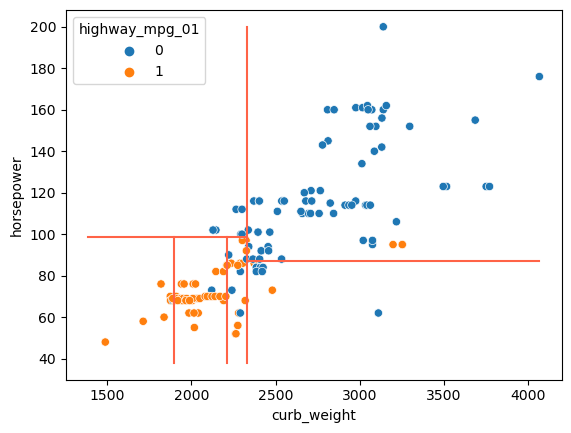

In [6]:
# 散布図と区切り線を描画
sns.scatterplot(x=df.curb_weight, y=df.horsepower, hue=df.highway_mpg_01)
plt.plot([2327.0, 2327.0], [df.horsepower.min() - 10, df.horsepower.max()], color='tomato')
plt.plot([2327.0, df.curb_weight.max()], [87.0, 87.0], color='tomato')
plt.plot([df.curb_weight.min() - 100, 2327.0], [98.5, 98.5], color='tomato')
plt.plot([2212.5, 2212.5], [df.horsepower.min() - 10, 98.5], color='tomato')
plt.plot([1895.0, 1895.0], [df.horsepower.min() - 10, 98.5], color='tomato')